# Question 2: Applied ML

In this part, we will study the [20 newsgroups dataset](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)
and train a classifier.
The dataset contains emails from 20 different news groups. Our goal is to train a classifier able to assign the the most likely newsgroup to each email by analyzing its content.

We will first download the dataset and take a look at the available data. Then, we will train multiple random forest classifiers. Each of them will have different hyper parameters. We will then select the hyperparameters and classifier leading to the best score according to cross-validation on a subset of our data.
Finally, we will validate the classifier on 10% of the data that we kept on the side and analyse the results we obtain.

In [9]:
# Import dependencies for part 2
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from email.parser import Parser as EmailParser
import sklearn
import pandas
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# Download the training dataset to `~/scikit_learn_data/20news_home` then load it to a variable
newsgroups = fetch_20newsgroups(subset='train')

# Dataset description

[Official description](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)

In [11]:
# Check the available keys
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

The loaded data contains the following properties:

- `data`: List of 11314 strings representing the messages.
- `filenames`: Absolute path to the downloaded file containing the message (11314 items).
- `target_names`: List of the names of the 20 newsgroups:
  ```
  ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
  ```
- `target`: List of ids for the targets: from 0 to 19 referencing the targets defined in `target_names`.
- `DESCR`: No value (`None`)
- `description`: String describing the dataset: `'the 20 newsgroups by date dataset'`

The messsages are formatted as emails: they have a header followed by a blank line and then the body with the actual text content. 
For example, you can view the message with the id `0` below.

Here are some observations:
- The most common header seem to be `From`, `Subject`, `Organization` and `Lines` 
- Messages `754`, `8000` and others have quotes
- Message `1704` seems to have an attachment (or manually pasted source code)

In [12]:
# Set the message id to view specific messages
msg_id = 0
print(f"Category: {newsgroups.target_names[newsgroups.target[msg_id]]}\n")
print(newsgroups.data[msg_id])

Category: rec.autos

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







## Dataframe

We will clean the data and place them in a dataframe to have them easily available.

The goal of cleaning the data is to avoid the classifier to use informations such as headers (author, organization...), signatures or quotes to classify the data. Instead we want it to use the text content of the body of the message.

We use the the `_raw` suffix for the original email, `_clean` for the one without any quotes, headers and footers. (The base value is the email without its headers)

In [13]:
# Use the builtin function to clean the mails
newsgroups_clean = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

In [14]:
def read_header_or_none(headers, name):
    """
    Tries to read the header `name` from `headers`, else returns `None`.
    """
    if name in headers:
        return headers[name]
    return None

In [17]:
def create_entry(label, label_id, subject, body, from_, organization, raw, clean):
    return {
        "label": label,
        "label_id": label_id,
        "subject": subject,
        "body": body,
        "from": from_,
        "organization": organization,
        "raw": raw,
        "clean": clean
    }

In [18]:
def create_df(emails, cleaned_emails, labels, label_ids):
    email_parser = EmailParser()
    entries = []
    for email, cleaned_email, label_id in zip(emails, cleaned_emails, label_ids):
        label = labels[label_id]
        parsed_email = email_parser.parsestr(email, headersonly=False)
        body = parsed_email.get_payload()
        headers = dict(parsed_email.items())
        subject = read_header_or_none(headers, "Subject")
        from_ = read_header_or_none(headers, "From")
        organization = read_header_or_none(headers, "Organization")
        entry = create_entry(label, label_id, subject, body, from_, organization, email, cleaned_email)
        entries.append(entry)
    return pandas.DataFrame(entries)
    
    
    

In [20]:
news_df = create_df(newsgroups.data, newsgroups_clean.data, newsgroups.target_names, newsgroups.target)

In [22]:
news_df.head(5)

,body,clean,from,label,label_id,organization,raw,subject
0,I was wondering if anyone out there could enl...,I was wondering if anyone out there could enli...,lerxst@wam.umd.edu (where's my thing),rec.autos,7,"University of Maryland, College Park",From: lerxst@wam.umd.edu (where's my thing)\nS...,WHAT car is this!?
1,A fair number of brave souls who upgraded thei...,A fair number of brave souls who upgraded thei...,guykuo@carson.u.washington.edu (Guy Kuo),comp.sys.mac.hardware,4,University of Washington,From: guykuo@carson.u.washington.edu (Guy Kuo)...,SI Clock Poll - Final Call
2,"well folks, my mac plus finally gave up the gh...","well folks, my mac plus finally gave up the gh...",twillis@ec.ecn.purdue.edu (Thomas E Willis),comp.sys.mac.hardware,4,Purdue University Engineering Computer Network,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,PB questions...
3,Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...,\nDo you have Weitek's address/phone number? ...,jgreen@amber (Joe Green),comp.graphics,1,Harris Computer Systems Division,From: jgreen@amber (Joe Green)\nSubject: Re: W...,Re: Weitek P9000 ?
4,"From article <C5owCB.n3p@world.std.com>, by to...","From article <C5owCB.n3p@world.std.com>, by to...",jcm@head-cfa.harvard.edu (Jonathan McDowell),sci.space,14,"Smithsonian Astrophysical Observatory, Cambrid...",From: jcm@head-cfa.harvard.edu (Jonathan McDow...,Re: Shuttle Launch Question


TODO: check number of empty messages (ex: 754)

In [11]:
# Display an example of filtered email, you can compare it with the original mail a few cells above.
newsgroups_train.data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

# Features computation

In [24]:
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(news_df["clean"])
labels = numpy.array(news_df["label_id"])

In [25]:
features.shape

(11314, 101631)

In [26]:
def create_permutation(n: int, rand_state = None):
    """
    Create a ranom permutation of size `n`.
    
    :param n: Size of the permutation
    :param rand_state: Random state to use to create the permutation.
    :return: A 1D numpy ndarray of size. It contains a permutation of integers from 0 to n-1
    """
    if rand_state is None:
        rand_state = numpy.random.RandomState()
    return rand_state.permutation(n)

In [29]:
def split_data(features, labels, ratios, rand_state = None):
    """
    Pseudo-randomly splits a dataset into smaller datasets of the provided size.
    
    This is is similar to `sklearn.model_selection.train_test_split` but allows
    to split the data into more than two sets and returns the original indexes.
    
    :param features: Numpy array of features
    :param labels: Numpy array of labels
    :param ratios: List of sizes of the first n-1 groups expressed as ratios of
                   the total size. The last group will have the remaining items.
    :param rand_state: Random state used to create the permutation
    :return: A list of groups of tuples (old_indexes, features, labels)
    """
    from math import floor
    if rand_state is None:
        rand_state = numpy.random.RandomState()
    
    row_count = features.shape[0]
    permutation = create_permutation(row_count, rand_state)
    
    
    split_indexes = [0]
    cur_ratio = 0
    for ratio in ratios:
        cur_ratio += ratio
        split_index = floor(cur_ratio * row_count)
        split_indexes.append(split_index)
    split_indexes.append(row_count)
    
    result = []
    for i in range(len(split_indexes) - 1):
        start_index = split_indexes[i]
        end_index = split_indexes[i + 1]
        old_indexes = permutation[start_index:end_index]
        cur_features = features[old_indexes]
        cur_labels = labels[old_indexes]
        result.append((old_indexes, cur_features, cur_labels))
    
    return result

In [30]:
def evaluate_parameters(n_estimators, max_depth, features, labels, rounds=3):
    """
    Get the score and classifier for the a model using random forests with the hyper parameters
    `n_estimators` and `max_depth` cross-validated with `features` and `labels`.
    
    The cross validation is repeated `rounds` times and the result is the median value.
    For each round, 10% of the original dataset is used for tests, the remaining for training.
    These test and train datasets are selected randomly for each round.
    
    The goal of randomizing the rounds and returning the median is to reduce overfitting.
    """
    evaluated = []
    for _ in range(rounds):
        (test, train) = split_data(features, labels, [0.1 / 0.9])
        _, test_features, test_labels = test
        _, train_features, train_labels = train

        classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        trained_classifier = classifier.fit(train_features, train_labels)
        predicted_test_labels = trained_classifier.predict(test_features)
        unique_labels = numpy.unique(predicted_test_labels)
        score = sklearn.metrics.f1_score(test_labels, predicted_test_labels, average='macro', labels=unique_labels)
        evaluated.append((score, trained_classifier))

    return sorted(evaluated)[rounds // 2] # return median

In [31]:
def grid_search(n_estimators_range, max_depth_range, features, labels):
    """
    Performs a grid search on the hyperparameters `n_estimators` and `max_depth` to find the best classifier.
    
    This is similar to `sklearn.model_selection.GridSearchCV`.
    
    Provide the values to search as ranges. The values must be strictly positive integers
    for both hyperparameters.
    The functions returns a dictionary with the keys:
    - params: Combination of parameters leading to the highest score
    - score: Highest score achieved
    """
    from ipywidgets import FloatProgress
    from IPython.display import display
    
    # Display a progress bar since the computation can take some time
    params_count = len(n_estimators_range) * len(max_depth_range)
    progress_bar = FloatProgress(min=0, max=params_count)
    display(progress_bar)
    
    result = None
    cur_param = 0
    for n_estimators in n_estimators_range:
        for max_depth in max_depth_range:
            progress_bar.value = cur_param
            score, classifier = evaluate_parameters(n_estimators, max_depth, features, labels)
            if result is None or score > result["score"]:
                result = {"score": score, "params": (n_estimators, max_depth), "classifier": classifier}
            cur_param += 1
    progress_bar.value = params_count
    return result


In [32]:
# Split the data: keep 10% on the side for final validation and 90% for training.
(validate, test_train) = split_data(features, labels, [0.1])

In [38]:
# TODO: https://en.wikipedia.org/wiki/Renard_series
renard_serie5 = [1, 2, 4, 6, 10, 16, 25, 40, 63, 100, 160, 250, 400, 630]

# Can take a few hours and a few GB of RAM.
best = grid_search(renard_serie5, renard_serie5, test_train[1], test_train[2])

In [33]:
best = grid_search([630], [40], test_train[1], test_train[2])

A Jupyter Widget

In [35]:
# Display the best hyperparameters we found with its score (obtained with cross validation on 90% of the data)
best

{'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=40, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=630, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'params': (630, 40),
 'score': 0.65000215115521343}

It seems that the best parameters are around. TODO

We will now apply the classifier to the validation dataset.
According to the official documentation linked to the dataset, we can expect about 75% success rate.

In [36]:
_, validate_features, validate_labels = validate
predicted_validate_labels =  best["classifier"].predict(validate_features)
sklearn.metrics.f1_score(validate_labels, predicted_validate_labels, average='macro')

0.61896284763721143

TODO: We can do better
We obtained a relatively good score, close to our expectations.

In [39]:
# Split the data: keep 10% on the side for final validation and 90% for training.
(validate2, test_train2) = split_data(features, labels, [0.1])
small_renard_serie20 = [25, 28, 31, 35, 40, 45, 50, 56, 63]
large_renard_serie20 = [400, 450, 500, 560, 630, 710, 800, 900, 1000, 1120, 1250,1400]
# Can take a few hours and 5-6GB of RAM.
# best = grid_search(renard_serie, renard_serie, test_train[1], test_train[2])
# best

stat = evaluate_parameters(1000, 50, test_train[1], test_train[2], rounds=1)
stat

(0.64329762257926615,
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=50, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))

In [40]:
validate_old_indexes2, validate_features2, validate_labels2 = validate2
predicted_validate_labels2 =  stat[1].predict(validate_features2)
sklearn.metrics.f1_score(validate_labels2, predicted_validate_labels2, average='macro')

0.89112179943751502

In [42]:
best_classifier = stat[1]

To better understand where the errors come from, we will display a **confusion matrix**. Each cell `(i, j)` represents the number of items in the newsgroup `i` but predicted in `j`.

In [43]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
confusion_matrix = sklearn.metrics.confusion_matrix(validate_labels2, predicted_validate_labels2)

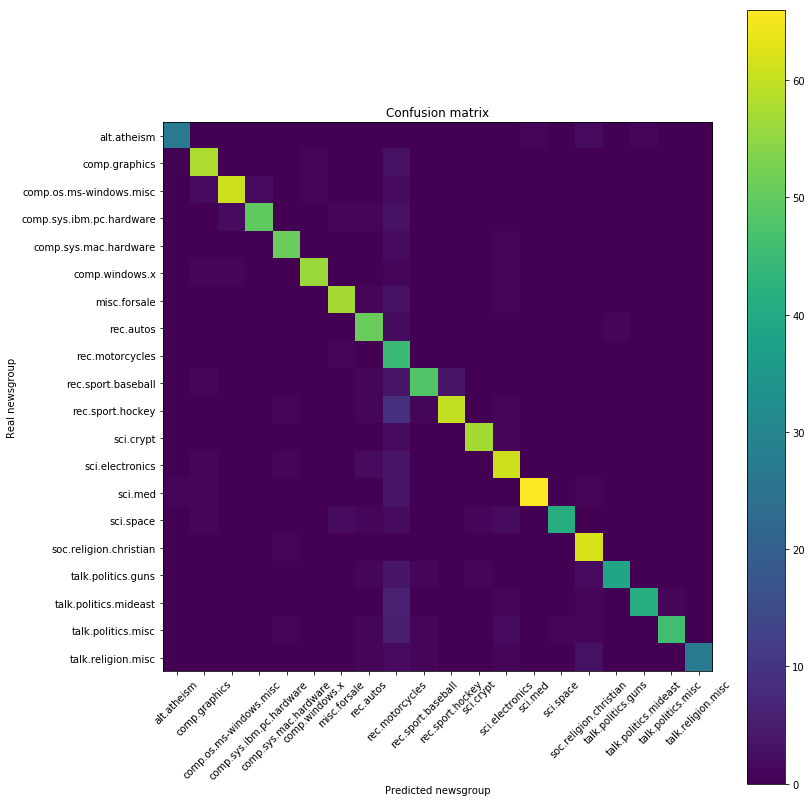

In [45]:
plt.figure(figsize=(12,12))
figure = plt.imshow(confusion_matrix, interpolation='nearest')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = numpy.arange(len(newsgroups.target_names))
plt.xticks(tick_marks, newsgroups.target_names, rotation=45)
plt.yticks(tick_marks, newsgroups.target_names)
plt.ylabel('Real newsgroup')
plt.xlabel('Predicted newsgroup')
plt.tight_layout()

We see that the main issue with the classifier we obtained is that many rows are incorectly classified as `rec.autos` (id `7`).

In [58]:
validate_data2 = numpy.asarray(newsgroups_train.data)

MemoryError: 

In [ ]:
validate_old_indexes2

In [52]:
rec_autos_id = 7
predicted_rec_autos_mask = predicted_validate_labels2 == rec_autos_id
not_real_rec_autos_mask = validate_labels2 != rec_autos_id
mispredicated_rec_autos_mask = predicted_rec_autos_mask & not_real_rec_autos_mask
invalid_rec_autos_data = validate_data2[mispredicated_rec_autos_mask]
invalid_rec_autos_data

MemoryError: 

In [ ]:
feature_importances_